# Intuition for yolort

In [1]:
import cv2
import torch

from yolort.utils import Visualizer, get_image_from_url, read_image_to_tensor
from yolort.v5.utils.downloads import safe_download

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Read an image

Let's request and pre-process the images that to be detected.

In [3]:
img_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/bus.jpg"
# img_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/zidane.jpg"
img_raw = get_image_from_url(img_source)
img = read_image_to_tensor(img_raw)
img = img.to(device)

images = [img]

## Model Definition and Initialization

In [4]:
score_thresh = 0.55
stride = 64
img_h, img_w = 640, 640

In [5]:
from yolort.models import yolov5n6

In [6]:
model = yolov5n6(pretrained=True, score_thresh=score_thresh, size=(img_h, img_w))

In [7]:
model = model.eval()
model = model.to(device)

In [8]:
# Perform inference on an image tensor
model_out = model(images)

/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Verify the PyTorch backend inference results

In [9]:
model_out[0]['boxes'].cpu().detach()

tensor([[ 32.27846, 225.15259, 811.47729, 740.91077],
        [ 50.42178, 387.48911, 241.54393, 897.61035],
        [219.03334, 386.14346, 345.77686, 869.02582],
        [678.05023, 374.65341, 809.80341, 874.80621]])

*Target outputs of boxes (yolov5n6, with shape of 1080x810):*

```
tensor([[ 32.27846, 225.15259, 811.47729, 740.91077],
        [ 50.42178, 387.48911, 241.54393, 897.61035],
        [219.03334, 386.14346, 345.77686, 869.02582],
        [678.05023, 374.65341, 809.80341, 874.80621]])
```

In [10]:
model_out[0]['scores'].cpu().detach()

tensor([0.88238, 0.84486, 0.72629, 0.70077])

*Target outputs of scores: (`yolov5n6`, with shape of 1080x810)*

```
tensor([0.88238, 0.84486, 0.72629, 0.70077])
```

In [11]:
model_out[0]['labels'].cpu().detach()

tensor([5, 0, 0, 0])

*Target outputs of labels:*

```
tensor([5, 0, 0, 0])
```

## Detection output visualisation

First let's get the labels of COCO datasets.

Get label names first.

In [12]:
# label_path = "https://raw.githubusercontent.com/zhiqwang/yolov5-rt-stack/main/notebooks/assets/coco.names"
label_source = "https://huggingface.co/spaces/zhiqwang/assets/resolve/main/coco.names"
label_path = label_source.split("/")[-1]
safe_download(label_path, label_source)

  0%|          | 0.00/621 [00:00<?, ?B/s]

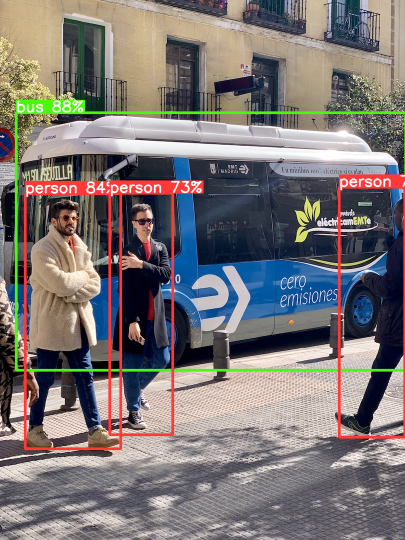

In [13]:
v = Visualizer(img_raw, metalabels=label_path)
v.draw_instance_predictions(model_out[0])
v.imshow(scale=0.5)

## Scripting YOLOv5

In [14]:
# TorchScript export
print(f'Starting TorchScript export with torch {torch.__version__}...')
export_script_name = 'yolov5n6.torchscript.pt'  # filename

Starting TorchScript export with torch 1.10.2+cu113...


In [15]:
model_script = torch.jit.script(model)
model_script.eval()
model_script = model_script.to(device)

In [16]:
# Save the scripted model file for subsequent use (Optional)
model_script.save(export_script_name)

## Inference on TorchScript Backend

In [17]:
out = model(images)
out_script = model_script(images)

/coding/yolov5-rt-stack/yolort/models/yolo.py:179: UserWarning: YOLO always returns a (Losses, Detections) tuple in scripting.
  warnings.warn("YOLO always returns a (Losses, Detections) tuple in scripting.")
/coding/yolov5-rt-stack/yolort/models/yolov5.py:180: UserWarning: YOLOv5 always returns a (Losses, Detections) tuple in scripting.
  warnings.warn("YOLOv5 always returns a (Losses, Detections) tuple in scripting.")


## Verify the Inference Output on LibTorch backend

In [18]:
for k, v in out[0].items():
    torch.testing.assert_allclose(out_script[1][0][k], v, rtol=1e-07, atol=1e-09)

print("Exported model has been tested with libtorch, and the result looks good!")

Exported model has been tested with libtorch, and the result looks good!


### Comparing Inference Time between `pytorch` and `libtorch`

**Time consumed on PyTorch backend**

In [19]:
%%timeit
with torch.no_grad():
    out = model(images)

23.8 ms ± 3.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Time consumed on LibTorch backend**

In [20]:
# Dummy run once for torchscript
with torch.no_grad():
    out_script = model_script(images)

In [21]:
%%timeit
with torch.no_grad():
    out_script = model_script(images)

14 ms ± 564 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
